# Time series - Time series forecasting using statistical and machine learning models
- Resource (original video): https://www.youtube.com/watch?v=_vQ0W_qXMxk
- Data source: https://fred.stlouisfed.org/series/CUUS0000SAF116, https://fred.stlouisfed.org/series/CPIAUCSL/

## VAR model agenda
1. data visualization: time series plot, ACF, PACF for each series and cross-correlation plot
1. Determine the transformation to make it stationarity
1. model selection (that amounts to order selection of VAR(p))
1. Find model estimation
1. Model diagnostic
1. Forecasting

### 1. Basic visualization

In [1]:
# Load dataset
# U.S. Alcoholic beverages price
file_api = '/Users/db91057/Documents/Project/tutorial/timeSeries/data/CSUSHPISA.csv'  # CSUSHPISA # CUUS0000SAF116
# U.S. Consumer Price Index for All Urban Consumers: All Items
file_cpi = '/Users/db91057/Documents/Project/tutorial/timeSeries/data/CPIAUCSL.csv'

In [2]:
import pandas as pd
data_api = pd.read_csv(file_api,skiprows = [0], names = ['DATE', 'AlcoholPriceIndex'])
data_cpi = pd.read_csv(file_cpi,skiprows = [0], names = ['DATE', 'ConsumerPriceIndex'])

In [3]:
series = data_api.merge(data_cpi, left_on='DATE', right_on='DATE', how='inner')

In [4]:
series['DATE']=pd.to_datetime(series['DATE'], format='%Y-%m-%d')
series=series.set_index('DATE')

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Examine the patters of dataset
def tsplot(y, title, lags=None, figsize=(12,8)):
    """
    Examine the patterns of dataset along with the time series plot and histogram
    """
    fig = plt.figure(figsize=figsize)
    layout  = (2,2)
    ts_ax   = plt.subplot2grid(layout, (0,0))
    hist_ax = plt.subplot2grid(layout, (0,1))
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title, fontsize=14, fontweight ='bold')
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title("Histogram")
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

/Users/db91057/anaconda/envs/tensorflow_py3/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  return f(*args, **kwds)


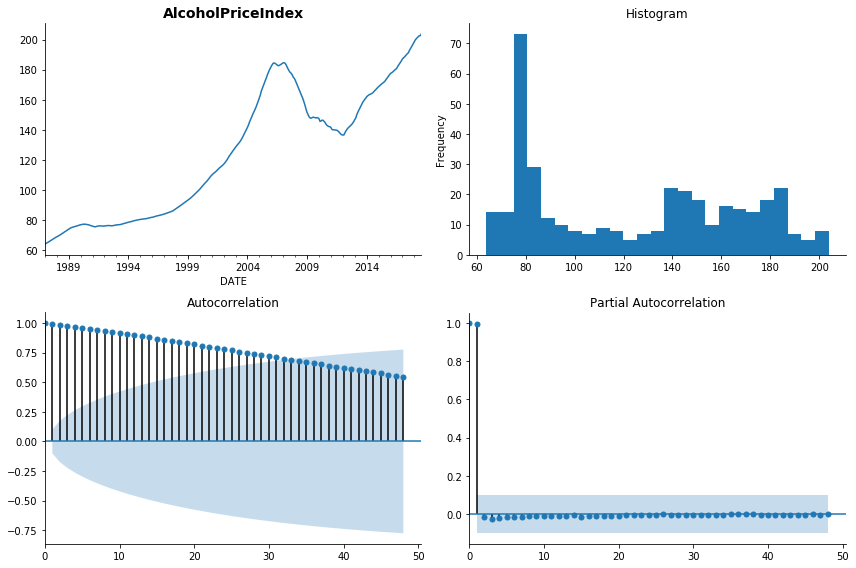

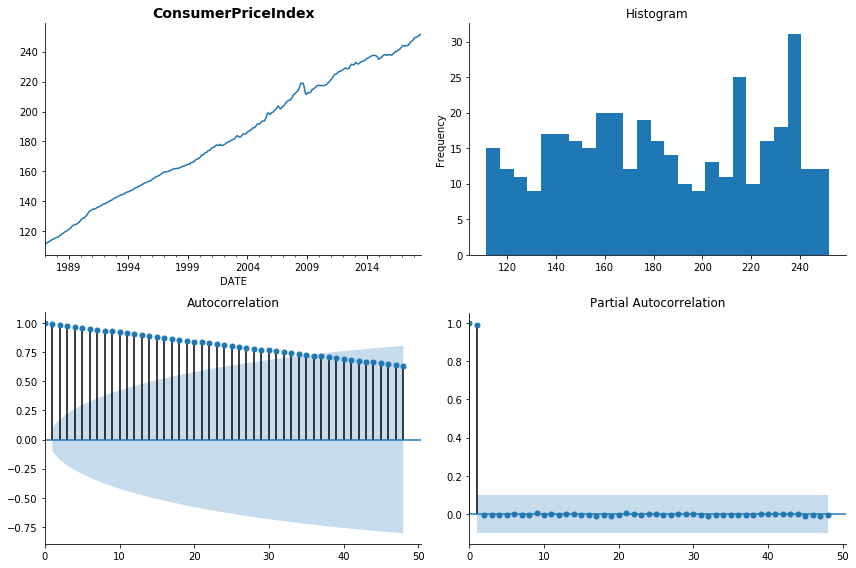

In [6]:
num_var= len(series.iloc[1,:])
for i in range(0, num_var):
    tsplot(series.iloc[:,i].dropna(), title=series.columns[i], lags=48)

### Autocorrelation and Partial Autocorrelation
These two graphs captures the correlation of the two variables. First bar captures the correlation of the variable at t1 and t2. These two graphs are useful to identify the order of the ARIMA model. These are estimate of some correlation.
* Autocorrelation: A correlation of a variable with itself at different times.

### Comments
* Housing Price Index: Steep upward trend between 1999-2006, then crash between 2009-2012. Upward trend recently
* CPI: Steady upward trend
* There is no visible seasonality for both variables. In order to use VAR model, you need to remove the seasonality. It looks like I don't have for this dataset.

### Notion of stationarity
* You need this to apply VAR
* There are two notion of stationarity
* A time series x is said to be strictly stationary if mean, variance structure, and correlation structure change over time. This is a very strong condition, too stron gto be applied in practice; it implies that the distribution is unchanged for any time shift
* A weaker and more practical stationarity condition is that of weak stationarity (or second order stationarity). A time series x is said to be weakly stationary if it is mean, variance structure, and correlation structure do not change over time. It does not mean that the values don't change; but the mean of the series itself does not change. And correlation only depends on the time lag. 
* If a time series is second order stationary and the normality distributional assumption is imposed, then the series can be completely characterized by its mean and variance-covariance structure

### Now how does this apply to us?
* The above graphs are very trendy, meaning it is not good enough to apply VAR yet. 
* We need transformation: Applying first differencing or seasonal differencing to the log of the series should make the above two series stationary, a condition that is required by VAR model.
* For this sereis, I am only going to use l = 1, but if there is a seasonality (yearly trend), then you should consider using l = 12

In [7]:
import numpy as np
series_transformed = series.copy()
series_transformed['AlcoholPriceIndex']=np.log(series.iloc[:,0].diff(1))
series_transformed['ConsumerPriceIndex']=np.log(series.iloc[:,1].diff(1))

/Users/db91057/anaconda/envs/tensorflow_py3/lib/python3.4/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/db91057/anaconda/envs/tensorflow_py3/lib/python3.4/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Users/db91057/anaconda/envs/tensorflow_py3/lib/python3.4/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [8]:
pd.concat([series, series_transformed], axis = 1).tail(15)

,AlcoholPriceIndex,ConsumerPriceIndex,AlcoholPriceIndex,ConsumerPriceIndex
DATE,,,,
2017-06-01,190.698,244.032,-0.210721,-2.111965
2017-07-01,191.183,244.236,-0.723606,-1.589635
2017-08-01,192.718,245.262,0.428530,0.025668
2017-09-01,193.826,246.392,0.102557,0.122218
2017-10-01,195.012,246.583,0.170586,-1.655482
2017-11-01,196.212,247.411,0.182322,-0.188742
2017-12-01,197.433,247.910,0.199670,-0.695149
2018-01-01,198.736,249.245,0.264669,0.288931
2018-02-01,199.815,249.619,0.076035,-0.983499


NaN is there because I am looking at the different. Looks good. Now the series must be stationary. Let's see if that is true

In [9]:
series_transformed = series_transformed.replace([np.inf, -np.inf], np.nan)

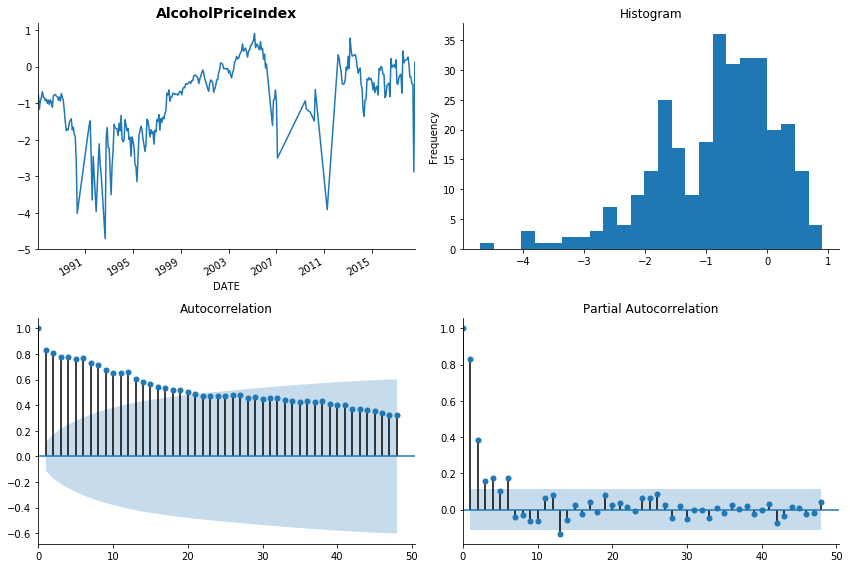

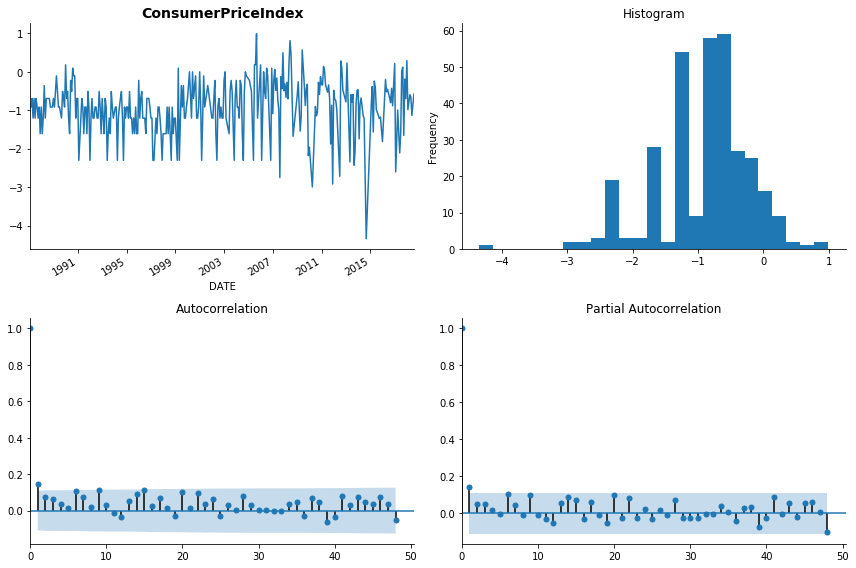

In [10]:
for i in range(0, num_var):
    tsplot(series_transformed.iloc[:,i].dropna(), title=series.columns[i], lags=48)

Correlation disappeared for the CPI, but not for the HPI. For HPI, the correlation still exists even after the transformation. 

In [11]:
# Estimation 
# Train-Test set split. I will use the last 3 entries as test set. For simplicity....
y_train = series_transformed
y_test = series_transformed.tail(3)
y_test

,AlcoholPriceIndex,ConsumerPriceIndex
DATE,,
2018-06-01,-0.487760,-1.133204
2018-07-01,-2.882404,-0.846298
2018-08-01,0.119559,-0.579818


### VAR model
* Stationarity requirement on the series.
* VAR model is meant for stationary series; it generates stationary time series with time invariant means, variances, and covariance structure.
* Stationarity assumption can be checked by.
* For non-staitonary series that can be transformed into stationary ones using simple differencing and if the series are not co-integrated, then we can still apply VAR("VAR in differences").
* A stochastic process is said covariance stationary if both its first and second moments exist and are constant over time.

### A note on predictive causality
* It does not mean causality in the "A causes B" (i.e., the cause of A leads to some effect on B) sense.
* When we say the series "y causes the series z, we mean y contains useful information for predicting z(in the least square sense), beyond the past histories of the other variables in the system

In [12]:
model = sm.tsa.VARMAX(y_train, order=(3,0), trend='c')
model_result=model.fit(maxiter=1000, disp=False)
print(model_result.summary())

/Users/db91057/anaconda/envs/tensorflow_py3/lib/python3.4/site-packages/statsmodels/tsa/vector_ar/var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


                                        Statespace Model Results                                       
Dep. Variable:     ['AlcoholPriceIndex', 'ConsumerPriceIndex']   No. Observations:                  380
Model:                                                  VAR(3)   Log Likelihood                -513.862
                                                   + intercept   AIC                           1061.725
Date:                                         Sun, 16 Dec 2018   BIC                           1128.708
Time:                                                 13:19:26   HQIC                          1088.304
Sample:                                             01-01-1987                                         
                                                  - 08-01-2018                                         
Covariance Type:                                           opg                                         
Ljung-Box (Q):                    nan, nan   Jarque-Bera (JB):  

/Users/db91057/anaconda/envs/tensorflow_py3/lib/python3.4/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/db91057/anaconda/envs/tensorflow_py3/lib/python3.4/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/db91057/anaconda/envs/tensorflow_py3/lib/python3.4/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [13]:
# You may wonder why we use VAR3 (why not 4?) and here is why...

## Model Selection (or order selection in the case of VAR(p))

In [14]:
aic = []
for i in range(5):
    i+=1
    model=sm.tsa.VARMAX(y_train, order=(i,0), trend='c')
    model_result=model.fit(maxiter=1000,disp=False)
    print('Order= ',i)
    print('AIC: ', model_result.aic)
    print("BIC: ", model_result.bic)
    print('HQIC: ', model_result.hqic)

/Users/db91057/anaconda/envs/tensorflow_py3/lib/python3.4/site-packages/statsmodels/tsa/vector_ar/var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


Order=  1
AIC:  1062.1614065581398
BIC:  1097.6229478326236
HQIC:  1076.2326898990389
Order=  2
AIC:  1057.2454582293396
BIC:  1108.4676845147053
HQIC:  1077.570645277305
Order=  3
AIC:  1061.7248164999264
BIC:  1128.7077277961737
HQIC:  1088.303907254958
Order=  4
AIC:  1062.1811383404997
BIC:  1144.9247346476288
HQIC:  1095.0141328025975
Order=  5
AIC:  1057.8850399209832
BIC:  1156.389321238994
HQIC:  1096.9719380901472


## Model Diagnostic

If the residual looks like a white noize, then it gives us assurance that we did okay.

/Users/db91057/anaconda/envs/tensorflow_py3/lib/python3.4/site-packages/statsmodels/tsa/vector_ar/var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


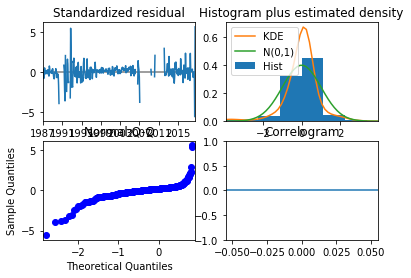

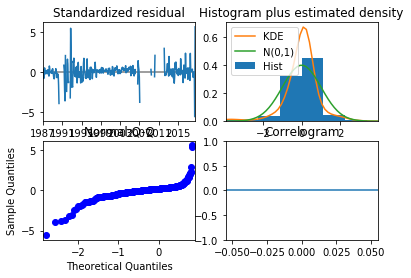

In [15]:
model = sm.tsa.VARMAX(y_train, order=(3,0), trend='c')
model_result=model.fit(maxiter=1000, disp=False)
model_result.plot_diagnostics()

## Impulse response functions of the endogenous variables
mpluse response functions of the endogenous variables

[<matplotlib.text.Text at 0x11b9ac588>, <matplotlib.text.Text at 0x11b7ae470>]

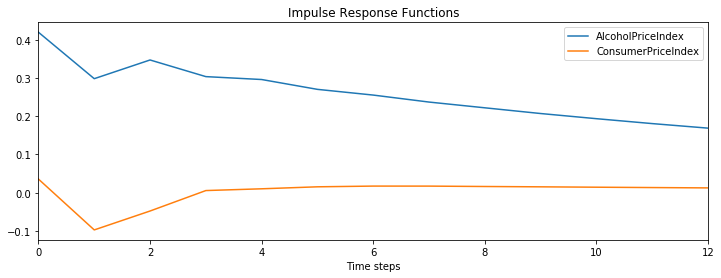

In [16]:
ax=model_result.impulse_responses(12, orthogonalized=True).plot(figsize=(12,4))
ax.set(xlabel='Time steps', title='Impulse Response Functions')

## Forecast
We need to un-log the estimation

In [17]:
y_train[:3]

,AlcoholPriceIndex,ConsumerPriceIndex
DATE,,
1987-01-01,NaN,NaN
1987-02-01,-0.778705,-0.916291
1987-03-01,-1.161552,-0.916291


In [18]:
# fit model
model = sm.tsa.VARMAX(y_train, order=(3,0), trend='c')
model_result=model.fit(maxiter=1000, disp=False)
# make prediction
yhat = model_result.predict(steps=1)
print(yhat[-3:])

/Users/db91057/anaconda/envs/tensorflow_py3/lib/python3.4/site-packages/statsmodels/tsa/vector_ar/var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


            AlcoholPriceIndex  ConsumerPriceIndex
2018-06-01          -0.477503           -0.818582
2018-07-01          -0.541454           -0.934300
2018-08-01          -2.213914           -0.282812


In [19]:
pd.concat([series['AlcoholPriceIndex'][-3:], np.exp(yhat['AlcoholPriceIndex'])*series['AlcoholPriceIndex'][-3:]], axis=1)[-3:]

,AlcoholPriceIndex,AlcoholPriceIndex
2018-06-01,202.565,125.657275
2018-07-01,202.621,117.905456
2018-08-01,203.748,22.263967


Right = Forecast

In [20]:
pd.concat([series['AlcoholPriceIndex'][-3:], np.exp(yhat['AlcoholPriceIndex'])*series['AlcoholPriceIndex'][-3:]], axis=1)[-3:]

,AlcoholPriceIndex,AlcoholPriceIndex
2018-06-01,202.565,125.657275
2018-07-01,202.621,117.905456
2018-08-01,203.748,22.263967


Right = Forecast

### Comments
* Using Var model... not so good

# A measure of Forecast error

In [21]:
from math import sqrt
from sklearn.metrics import mean_squared_error

VAR_forecast = np.exp(yhat['AlcoholPriceIndex'])*series['AlcoholPriceIndex']
rmse = sqrt(mean_squared_error(series['AlcoholPriceIndex'][-3:], VAR_forecast[-3:]))
print('Test RMSE: %.3f'%rmse)

Test RMSE: 123.865


# LSTM for Time Series (Regression) Forecasting
* Feed-forward type neural network does not preserve memory. So we use RNN, and LSTM. 

## RNN
Unlike feed-forward network, RNN has 'memory'. RNN take their inputs from both current input example they see as well as perceived previously in time, preserving their past inputs through the hidden state layer. Problem with basic RNN is that it has a hard time learning long-range dependency due to the so-called 'Vanishing (and exploding) gradient problem'. What it really means is that gradient contributions from 'far away' converges to zero at an exponential rate (because of all the multiplication of the weights inside)
## LSTM (Long Short Term Memory)
The key concept is gated cell, which control information flow via the 'gates'. 

## Steps to implementing a LSTM model in Keras
1. Load and parse the target and feature series
1. Formulate the series for a RNN supervised learning regression problem
1. Train-validation-test split
1. Scale all the series
1. Define the (initial) architecture of teh LSTM model
1. Train the model
1. Produce the forecast
1. Refine the architecture and repeat step 5-7 as needed

In [22]:
# Formulate the series for a RNN supervised learning regression problem
from pandas import DataFrame, concat

def timeseries_to_supervised(data, lag=1):
    """
    Return a dataframe and a numpy ndarray that can be used for RNN training
    """
    df=DataFrame(data)
    columns=[df.shift(i) for i in range(1, lag+1)]
    columns.append(df) # create a list of (lag+1) dimensions
    df=concat(columns, axis=1)
    df=df.dropna()
    series_values=df.values #convert the DataFrame to a np.ndarray
    
    return series_values,df

In [23]:
reframed, rf_df = timeseries_to_supervised(series)

In [24]:
reframed[:4]

array([[ 63.989, 111.4  ,  64.448, 111.8  ],
       [ 64.448, 111.8  ,  64.761, 112.2  ],
       [ 64.761, 112.2  ,  65.153, 112.7  ],
       [ 65.153, 112.7  ,  65.583, 113.   ]])

In [25]:
rf_df.head(3)

,AlcoholPriceIndex,ConsumerPriceIndex,AlcoholPriceIndex,ConsumerPriceIndex
DATE,,,,
1987-02-01,63.989,111.4,64.448,111.8
1987-03-01,64.448,111.8,64.761,112.2
1987-04-01,64.761,112.2,65.153,112.7


In [26]:
# Split dataset
from sklearn.model_selection import train_test_split

train, test = train_test_split(reframed, test_size=0.33, shuffle = False, random_state=42)

### Scale all the series
In the VAR model, staionarity was a requirement. But there is non like that here. Although, if you fit the model that is stationary, it is easier for the model, but it is not a requirement.
#### Why scale?
You don't want the unit of the variables to be too different. You normalize your series to have standard deviation.

In [27]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def scale(train,test):
    """
    Return the scaler, a scaled training series, and a scaled test series. 
    The purpose of returning the scaler is to use in the invert-transforming 
    the series when it comes to prediction
    """
    # fit a StandardScaler
    scaler=StandardScaler()
    scaler=scaler.fit(train)
    
    # scale training series
    train=train.reshape(train.shape[0], train.shape[1])
    train_scaled=scaler.transform(train)
    
    # scale test series (note that the mean and standard deviation are those of the training series)
    test=test.reshape(test.shape[0], test.shape[1])
    test_scaled=scaler.transform(test)
    
    return scaler, train_scaled, test_scaled

scaler, train_scaled, test_scaled = scale(train, test)

## Fit the model

In [28]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [29]:
# Fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful = True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    # It's very important to set shuffle=False for RNN
        model.reset_states()
    return model

## Train the model

In [30]:
import time
start_time = time.time()
batch_size = 1
nb_epoch = 500
n_neurons = 4
lstm_model=fit_lstm(train_scaled, batch_size, nb_epoch, n_neurons)
print('--- %s minutes ---'%(((time.time()-start_time)/60)))

--- 3.6799719174702963 minutes ---


## Produce the forecast

In [32]:
yhat = lstm_model.predict(test_scaled, verbose=0)

In [ ]:
pd.concat([series['AlcoholPriceIndex'][-3:], np.exp(yhat['AlcoholPriceIndex'])*series['AlcoholPriceIndex'][-3:]], axis=1)[-3:]

## Report performance

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error

LSTM_forecast = np.exp(yhat['AlcoholPriceIndex'])*series['AlcoholPriceIndex']
rmse = sqrt(mean_squared_error(series['AlcoholPriceIndex'][-3:], VAR_forecast[-3:]))
print('Test RMSE: %.3f'%rmse)

# Comparison of the approaches
Problems that are appropriate to be solved.
* VAR: Exclusively used for numeric data, although it is used in many different disciplines, such as economics and engineering
* LSTM: Can be applied to much more general problems for sequence data
  * data type: images, text, macroeconomic time series, financial time series, business time series, and other numeric series
  * time series forecasting
  * time series classification
  * anomaly detection (using time series)
 
Learn and remember remote past:
* VAR: require pre-specified lags(by choosing the model order)
* LSTM: does not require pre-specified window of lagged observations as inputs

Stationarity:
* VAR: requires that the series be stationary (or be transformed to stationary)
* LSTM: does not require stationary

Model implementation
* VAR: training time is very short and doesn't require a lot of time to tune the model
* LSTM: training time is much longer and require a lot of tuning to improve model performance